<a href="https://colab.research.google.com/github/johanjun/study_datascienceandpython/blob/main/oxford_pet(localization).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- ref : https://github.com/jwlee-ml/mobis2021

In [1]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import xml.etree.ElementTree as et

# Data load

In [2]:
## google drive에서 압축된 dataset download
import gdown
url = 'https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0'
fname = 'oxford_pet.zip'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0
To: /content/oxford_pet.zip
811MB [00:03, 263MB/s]


'oxford_pet.zip'

In [3]:
!ls -l

total 791576
-rw-r--r-- 1 root root 810565619 Jul 20 05:09 oxford_pet.zip
drwxr-xr-x 1 root root      4096 Jul 16 13:20 sample_data


In [4]:
## 압축풀기
!unzip -q oxford_pet.zip -d oxford_pet

In [5]:
## directory 설정
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'oxford_pet')
image_dir = os.path.join(data_dir, 'images')
bbox_dir = os.path.join(data_dir, 'annotations', 'xmls')
seg_dir = os.path.join(data_dir, 'annotations', 'trimaps')

In [6]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg'] #확장자 분리
print(len(image_files))

7390


In [7]:
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']
print(len(bbox_files))

3686


In [8]:
## image file들을 읽어서 channel이 3이 아닌 image는 삭제(xml도 같이)
for image_file in image_files:
  image_path = os.path.join(image_dir, image_file)
  bbox_file = os.path.splitext(image_file)[0]+'.xml'
  bbox_path = os.path.join(bbox_dir, bbox_file)
  image = Image.open(image_path)
  image_mode = image.mode
  if image_mode != 'RGB':
    print(image_file, image_mode)
    image = np.asarray(image)
    print(image.shape)
    os.remove(image_path)
    try:
      os.remove(bbox_path)
    except FileNotFoundError:
      pass

staffordshire_bull_terrier_2.jpg L
(282, 500)
Abyssinian_5.jpg RGBA
(150, 200, 4)
Abyssinian_34.jpg P
(202, 250)
Egyptian_Mau_139.jpg P
(250, 350)
Egyptian_Mau_14.jpg RGBA
(800, 582, 4)
Egyptian_Mau_177.jpg P
(175, 246)
staffordshire_bull_terrier_22.jpg L
(500, 364)
Egyptian_Mau_129.jpg L
(325, 299)
Egyptian_Mau_191.jpg P
(214, 300)
Egyptian_Mau_186.jpg RGBA
(275, 183, 4)
Egyptian_Mau_167.jpg P
(275, 183)
Egyptian_Mau_145.jpg P
(188, 216)


In [9]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

7378


In [10]:
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']
print(len(bbox_files))

3685


In [11]:
# class 생성
class_list = set()
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+', '', file_name)
    class_list.add(class_name)
class_list = list(class_list)
print(len(class_list))

37


In [12]:
class_list.sort()
class_list[:5]

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair']

In [15]:
class2idx = {cls:idx for idx, cls in enumerate(class_list)}
class2idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [16]:
bbox_files[:20]

['staffordshire_bull_terrier_17.xml',
 'British_Shorthair_189.xml',
 'Bengal_12.xml',
 'Birman_172.xml',
 'Egyptian_Mau_103.xml',
 'beagle_134.xml',
 'great_pyrenees_145.xml',
 'samoyed_147.xml',
 'beagle_12.xml',
 'american_pit_bull_terrier_183.xml',
 'Egyptian_Mau_173.xml',
 'Bombay_153.xml',
 'Birman_104.xml',
 'Russian_Blue_154.xml',
 'scottish_terrier_151.xml',
 'wheaten_terrier_132.xml',
 'Russian_Blue_152.xml',
 'British_Shorthair_124.xml',
 'english_cocker_spaniel_183.xml',
 'saint_bernard_169.xml']

In [26]:
IMG_SIZE = 224
N_BBOX = len(bbox_files)
N_TRAIN = 3000
N_VAL = N_BBOX - N_TRAIN

# TFRecord File 만들기

In [18]:
## TFRecord 저장할 directory와 file 경로 설정
tfr_dir = os.path.join(data_dir, 'tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'loc_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'loc_val.tfr')

In [19]:
## TFRecord writer 생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [20]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [21]:
shuffle_list = list(range(N_BBOX))
random.shuffle(shuffle_list)

train_idx_list = shuffle_list[:N_TRAIN]
val_idx_list = shuffle_list[N_TRAIN:]

In [ ]:
shuffle_list

In [23]:
for idx in train_idx_list:
  bbox_file = bbox_files[idx]
  bbox_path = os.path.join(bbox_dir, bbox_file)

  tree = et.parse(bbox_path)

  width = float(tree.find('./size/width').text)
  height = float(tree.find('./size/height').text)
  xmin = float(tree.find('./object/bndbox/xmin').text)
  xmax = float(tree.find('./object/bndbox/xmax').text)
  ymin = float(tree.find('./object/bndbox/ymin').text)
  ymax = float(tree.find('./object/bndbox/ymax').text)

  xc = (xmin + xmax) / 2.
  yc = (ymin + ymax) / 2.
  x = xc / width
  y = yc / height
  w = (xmax - xmin) / width
  h = (ymax - ymin) / height

  file_name = os.path.splitext(bbox_file)[0]
  image_file = file_name + '.jpg'
  image_path = os.path.join(image_dir, image_file)
  image = Image.open(image_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  class_name = re.sub('_\d+', '', file_name)
  class_num = class2idx[class_name]

  if file_name[0].islower():
    bi_cls_num = 0
  else:
    bi_cls_num = 1

  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num),
      'bi_cls_num': _int64_feature(bi_cls_num),
      'x': _float_feature(x),
      'y': _float_feature(y),
      'w': _float_feature(w),
      'h': _float_feature(h),
  }))
  writer_train.write(example.SerializeToString())

writer_train.close()

In [24]:
for idx in val_idx_list:
  bbox_file = bbox_files[idx]
  bbox_path = os.path.join(bbox_dir, bbox_file)

  tree = et.parse(bbox_path)

  width = float(tree.find('./size/width').text)
  height = float(tree.find('./size/height').text)
  xmin = float(tree.find('./object/bndbox/xmin').text)
  xmax = float(tree.find('./object/bndbox/xmax').text)
  ymin = float(tree.find('./object/bndbox/ymin').text)
  ymax = float(tree.find('./object/bndbox/ymax').text)

  xc = (xmin + xmax) / 2.
  yc = (ymin + ymax) / 2.
  x = xc / width
  y = yc / height
  w = (xmax - xmin) / width
  h = (ymax - ymin) / height

  file_name = os.path.splitext(bbox_file)[0]
  image_file = file_name + '.jpg'
  image_path = os.path.join(image_dir, image_file)
  image = Image.open(image_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  class_name = re.sub('_\d+', '', file_name)
  class_num = class2idx[class_name]

  if file_name[0].islower():
    bi_cls_num = 0
  else:
    bi_cls_num = 1

  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num),
      'bi_cls_num': _int64_feature(bi_cls_num),
      'x': _float_feature(x),
      'y': _float_feature(y),
      'w': _float_feature(w),
      'h': _float_feature(h),
  }))
  writer_val.write(example.SerializeToString())

writer_val.close()

# classification

In [27]:
## Hyper Parameters
N_CLASS = len(class_list)
N_EPOCHS = 40
N_BATCH = 40
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [28]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64),
              'x': tf.io.FixedLenFeature([], tf.float32),
              'y': tf.io.FixedLenFeature([], tf.float32),
              'w': tf.io.FixedLenFeature([], tf.float32),
              'h': tf.io.FixedLenFeature([], tf.float32)
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255. 

    cls_label = tf.cast(parsed_features['cls_num'], tf.int64)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.int64)

    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    gt = tf.stack([x, y, w, h], -1)

    return image, gt

In [29]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [30]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH)

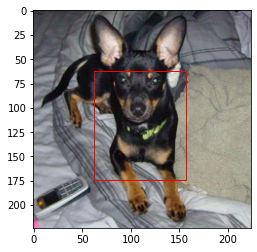

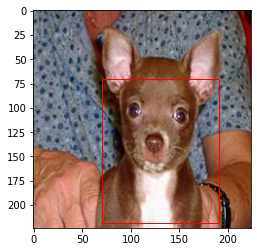

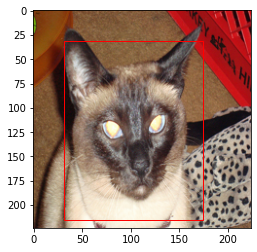

In [31]:
for image, gt in val_dataset.take(3):

  x = gt[:,0]
  y = gt[:,1]
  w = gt[:,2]
  h = gt[:,3]

  xmin = x[0].numpy() - w[0].numpy()/2.
  ymin = y[0].numpy() - w[0].numpy()/2.

  rect_x = int(xmin * IMG_SIZE)
  rect_y = int(xmin * IMG_SIZE)
  rect_w = int(w[0].numpy() * IMG_SIZE)
  rect_h = int(h[0].numpy() * IMG_SIZE)

  rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
  plt.axes().add_patch(rect)
  plt.imshow(image[0])
  plt.show()

## modeling

In [32]:
# Sequential API를 사용하여 model 구성
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='SAME', 
                                  input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(4, activation='sigmoid'))
    return model

In [33]:
def loss_fn(y_true, y_pred):
  return keras.losses.MeanSquaredError()(y_true, y_pred)

In [34]:
## Create model, compile & summary
model = create_model()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*10,
                                                          decay_rate=0.5,
                                                          staircase=True)

model.compile(keras.optimizers.RMSprop(lr_schedule), loss=loss_fn)

In [35]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/40
75/75 [==============================] - 21s 57ms/step - loss: 0.0243 - val_loss: 0.0218
Epoch 2/40
75/75 [==============================] - 4s 52ms/step - loss: 0.0221 - val_loss: 0.0209
Epoch 3/40
75/75 [==============================] - 5s 52ms/step - loss: 0.0199 - val_loss: 0.0185
Epoch 4/40
75/75 [==============================] - 5s 52ms/step - loss: 0.0184 - val_loss: 0.0171
Epoch 5/40
75/75 [==============================] - 4s 52ms/step - loss: 0.0168 - val_loss: 0.0169
Epoch 6/40
75/75 [==============================] - 4s 52ms/step - loss: 0.0153 - val_loss: 0.0161
Epoch 7/40
75/75 [==============================] - 4s 52ms/step - loss: 0.0141 - val_loss: 0.0165
Epoch 8/40
75/75 [==============================] - 4s 52ms/step - loss: 0.0128 - val_loss: 0.0172
Epoch 9/40
75/75 [==============================] - 4s 52ms/step - loss: 0.0116 - val_loss: 0.0145
Epoch 10/40
75/75 [==============================] - 4s 52ms/step - loss: 0.0105 - val_loss: 0.0143
Epoch 11

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


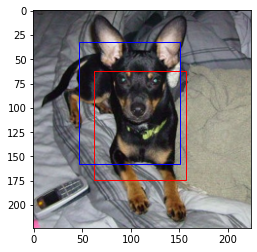

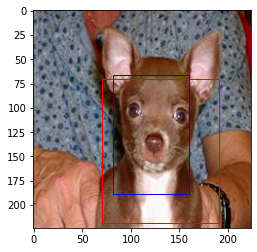

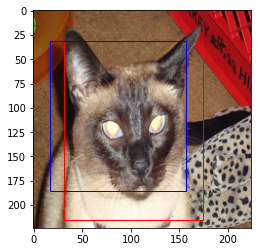

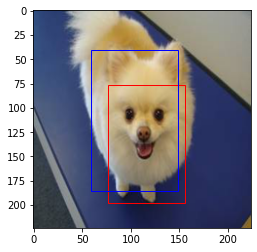

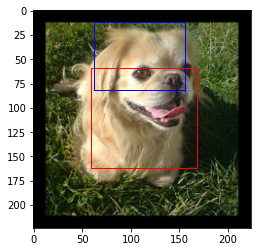

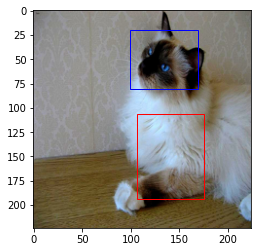

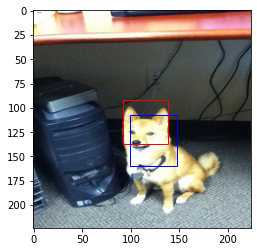

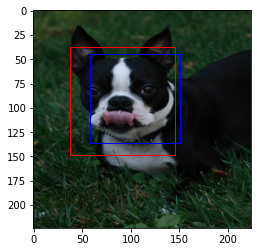

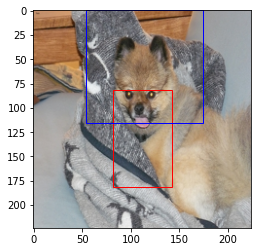

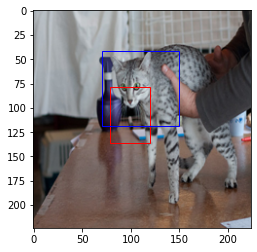

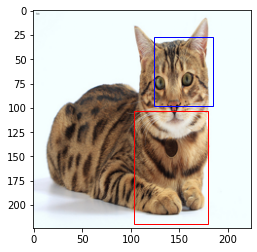

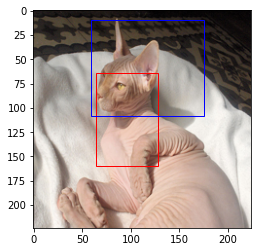

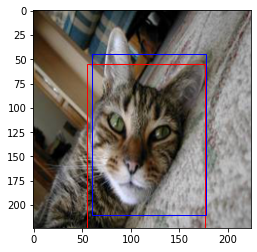

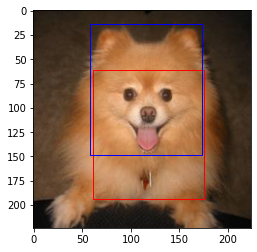

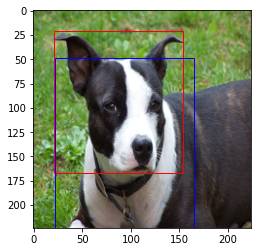

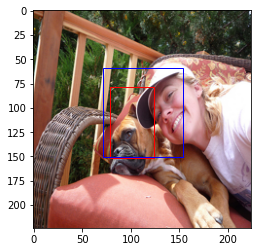

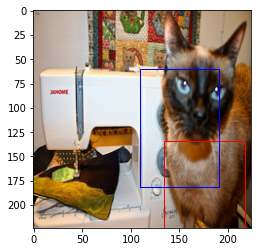

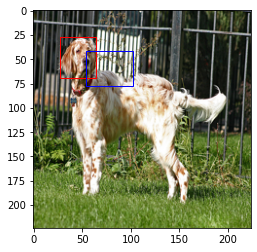

In [37]:
idx = 0
num_imgs = validation_steps

for val_data, val_gt in val_dataset.take(num_imgs):

  x = val_gt[:,0]
  y = val_gt[:,1]
  w = val_gt[:,2]
  h = val_gt[:,3]

  xmin = x[idx].numpy() - w[idx].numpy()/2.
  ymin = y[idx].numpy() - w[idx].numpy()/2.

  rect_x = int(xmin * IMG_SIZE)
  rect_y = int(xmin * IMG_SIZE)
  rect_w = int(w[idx].numpy() * IMG_SIZE)
  rect_h = int(h[idx].numpy() * IMG_SIZE)

  rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
  plt.axes().add_patch(rect)

  prediction = model.predict(val_data)
  pred_x = prediction[:,0]
  pred_y = prediction[:,1]
  pred_w = prediction[:,2]
  pred_h = prediction[:,3]

  pred_xmin = pred_x[idx] - pred_w[idx]/2.
  pred_ymin = pred_y[idx] - pred_w[idx]/2.

  pred_rect_x = int(pred_xmin * IMG_SIZE)
  pred_rect_y = int(pred_ymin * IMG_SIZE)
  pred_rect_w = int(pred_w[idx] * IMG_SIZE)
  pred_rect_h = int(pred_h[idx] * IMG_SIZE)

  pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h, fill=False, color='blue')
  plt.axes().add_patch(pred_rect)

  plt.imshow(val_data[idx])
  plt.show()